# Run this (imports)

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

# read

This code computes evaluation metrics for the outputs of a binary semantic segmentation (pixel classification) model.

I include an example folder named 'eval_folder'

**Important**

By default this code works with rasters up to 178,956,970 pixels (13377 x 13377 square raster)
<br>
You can run the code on larger images by disabling this limit (uncomment and run cell below)

In [2]:
# Image.MAX_IMAGE_PIXELS = None 

You will have to test with different raster sizes to see what can your memory (RAM) handle.
<br>
When I tried on my side I could handle a 50000 x 50000 raster (2.5b pixels), using about 50 GB of RAM.

I see two options if the input rasters are too large

* Split them into smaller tiles
* Resize them (section below)

## Optional: resize rasters

In [3]:
# define target image size
WIDTH = 10000
HEIGHT = 10000

In [4]:
size_tuple = (WIDTH, HEIGHT)

# resize label
label = Image.open('label.tif')
label = label.resize(size_tuple, resample=Image.NEAREST)
label.save(f'label_{WIDTH}_{HEIGHT}.tif')

# resize pred raster
pred = Image.open('pred.tif')
pred = pred.resize(size_tuple, resample=Image.NEAREST)
pred.save(f'pred_{WIDTH}_{HEIGHT}.tif')

# Run this: Define eval metrics

In [26]:
# define function to calculate the Dice and IoU score for a given class id (by default class #1)
def calculate_metrics(cm, class_id=1): 
    TP = cm[class_id, class_id]  # true positives 
    FP = cm[:, class_id].sum() - TP  # false positives 
    FN = cm[class_id, :].sum() - TP  # false negatives 

    if TP == 0 and FP == 0 and FN == 0:
        test_dice = 1.0
        test_iou = 1.0
    else:
        # calculate dice
        test_dice = 2 * TP / (2 * TP + FP + FN + 1e-8) # small values to avoid divisions by 0

        # calculate iou
        test_iou = TP / (TP + FP + FN + 1e-8)

    return test_dice, test_iou

# Run one of the two below

## 1. Evaluate on a single example

**Input rasters**
* label.tif 
<br>
The groud truth labels
<br>
*a 8-bit raster of binary (0 and 1) values, where 1 is your target class.*
* pred.tif
<br>
The model output (prediction)
<br>
*a 8-bit raster of binary (0 and 1) values, where 1 is your target class.*

**Output**
* Evaluation metrics
<br>
IoU and Dice score
<br>
*printed in the notebook*

Dice for class 1: 0.7763
IoU for class 1: 0.6344


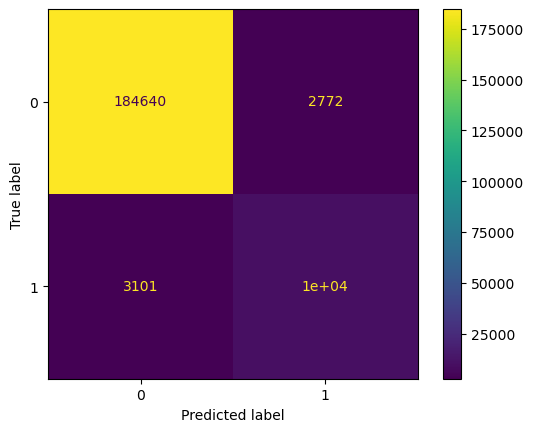

In [27]:
# define input raster paths
pred_raster_path = 'eval_folder/preds/pred_1.tif'
label_raster_path = 'eval_folder/labels/label_1.tif'

# open tiffs with pillow
pred = Image.open(pred_raster_path)
label = Image.open(label_raster_path)

# convert to numpy arrays for faster calculation
pred = np.array(pred).flatten()
label = np.array(label).flatten()


# shape check
if pred.shape != label.shape:
    raise ValueError(f"Pred and label rasters have different shapes!")

# compute confusion matrix with scikit-learn confusion matrix tool
cm = confusion_matrix(pred, label)

# calculate dice with function
test_dice, test_iou = calculate_metrics(cm, class_id=1)
print(f'Dice for class 1: {test_dice:.4f}')
print(f'IoU for class 1: {test_iou:.4f}')

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## 2. Batch eval, multiple tiles

**Inputs**

--eval_folder
<br>-----/labels
<br>--------/label_1.tif
<br>--------/label_2.tif
<br>--------/label_n.tif
<br>-----/preds
<br>--------/pred_1.tif
<br>--------/pred_2.tif
<br>--------/pred_n.tif

**where**

* label.tif 
<br>
The groud truth labels
<br>
*a 8-bit raster of binary (0 and 1) values, where 1 is your target class.*
* pred.tif
<br>
The model output (prediction)
<br>
*a 8-bit raster of binary (0 and 1) values, where 1 is your target class.*

**Outputs**
* Dice and IoU scores printed as the batch is processed
* Avg Dice and avg IoU printed as the batch is processed
* eval_metrics.csv
<br>A table with the dice and iou value per prediction
<br>*columns= pred_name; Dice; IoU*

In [28]:
# DEFINE PATH TO EVAL_FOLDER
FOLDER_PATH = 'eval_folder'

In [ ]:
pred_folder_path = f'{FOLDER_PATH}/preds'
label_folder_path = f'{FOLDER_PATH}/labels'

n = 0 # simple tracking counter

# empty dictionaries to store test metrics per test sample
dice_scores_dict = {}
iou_scores_dict = {}

sum_dice = 0 # will track avg_dice
sum_iou = 0 # will track avg_iou

pred_list = os.listdir(pred_folder_path)

print(f'{datetime.now()}: Calculating metrics for {pred_folder_path}...')
for pred_name in pred_list:
    if pred_name.startswith('pred') and pred_name.endswith('.tif'):
        print(f'{pred_name} is an invalid file. Skipping.')
        continue

    n += 1

    # define input raster paths
    pred_raster_path = os.path.join(pred_folder_path, pred_name)
    label_name = pred_name.replace('pred','label')
    label_raster_path = os.path.join(label_folder_path, label_name)

    # open tiffs with pillow
    pred = Image.open(pred_raster_path)
    label = Image.open(label_raster_path)

    # convert to numpy arrays for faster calculation
    pred = np.array(pred).flatten()
    label = np.array(label).flatten()

    # shape check
    if pred.shape != label.shape:
        raise ValueError(f'Pred and label rasters {n} have different shapes!')

    # compute confusion matrix with scikit-learn confusion matrix tool
    # cm = confusion_matrix(pred, label)
    
    cm = confusion_matrix(label, pred, labels=[0, 1])


    # calculate dice with function
    test_dice, test_iou = calculate_metrics(cm, class_id=1)

    # average metrics
    sum_dice += test_dice
    sum_iou += test_iou
    avg_dice = sum_dice / n
    avg_iou = sum_iou / n

    dice_scores_dict[pred_name] = test_dice
    iou_scores_dict[pred_name] = test_iou

    print(f'Tile {n}: Dice for class 1: {test_dice:.4f}', f'IoU: {test_iou:.4f}')
    print(f'{datetime.now()}: Processed tile {n}/{len(os.listdir(pred_folder_path))}')
    print(f'Average Dice: {avg_dice:.4f}', f'Average IoU: {avg_iou:.4f}')

print(f'Total avg Dice: {avg_dice:.4f}', f'Total avg IoU: {avg_iou:.4f}')
# create output table
df = pd.DataFrame({
    'Dice': dice_scores_dict,
    'IoU': iou_scores_dict
})
df.reset_index(inplace=True)
df.rename(columns={'index': 'pred_name'})

df['Dice'] = df['Dice'].round(4)
df['IoU'] = df['IoU'].round(4)

# save table
df.to_csv('eval_metrics.csv')

#print the df
df

2025-07-17 14:42:59.747635: Calculating metrics for pred_1.tif...
Tile 1: Dice for class 1: 0.7763 IoU: 0.6344
2025-07-17 14:42:59.755276: Processed tile 1/4
Average Dice: 0.7763 Average IoU: 0.6344
2025-07-17 14:42:59.755558: Calculating metrics for pred_2.tif...
Tile 2: Dice for class 1: 1.0000 IoU: 1.0000
2025-07-17 14:42:59.762302: Processed tile 2/4
Average Dice: 0.8882 Average IoU: 0.8172
2025-07-17 14:42:59.762484: Calculating metrics for pred_3.tif...
Tile 3: Dice for class 1: 0.5429 IoU: 0.3726
2025-07-17 14:42:59.768038: Processed tile 3/4
Average Dice: 0.7731 Average IoU: 0.6690
2025-07-17 14:42:59.768253: Calculating metrics for pred_4.tif...
Tile 4: Dice for class 1: 0.6602 IoU: 0.4928
2025-07-17 14:42:59.774765: Processed tile 4/4
Average Dice: 0.7449 Average IoU: 0.6249
Total avg Dice: 0.7449 Total avg IoU: 0.6249


,index,Dice,IoU
0,pred_1.tif,0.7763,0.6344
1,pred_2.tif,1.0000,1.0000
2,pred_3.tif,0.5429,0.3726
3,pred_4.tif,0.6602,0.4928
